# Saravanan, Karthik Sundaram -- Homework 5

**Due on Monday 15th April in class**

We use Stan to draw posterior samples for the infamous 8 schools example given in BDA by Gelman et al. (see p.119-p.124 in BDA for additional background). 

The 8 schools example looks at the SAT results in eight different schools which each had their own coaching program. The observation $y_j$ from school $j$ is a summary of the mean improvement in SAT score for that school relative to the intended national mean of about 500 (after some covariate adjustments), higher values are better. The hierarchical model for the full dataset is

$$ y_j \sim N(\theta_j,\sigma^2_j)\\\theta_j\sim N(\mu,\tau^2)\\\pi(\mu) \propto 1\\\pi(\tau) \propto 1, \tau>0$$

for $j=1,\dots,J$, where $J=8$. In this example the $\sigma_j^2$ are treated as known (because the number of pupils in each school were sufficiently large to estimate them precisely). 

## Problem 1
Use RStan or PyStan to obtain posterior samples of the unknown parameters $\mu,\tau,\theta_1,\dots,\theta_J$. You should make sure to:
- Provide a table and plots to summarize the posterior inference
- Comment on the convergence of the Markov chains.

You can follow one of these tutorials:
1. https://github.com/stan-dev/rstan/wiki/RStan-Getting-Started#how-to-use-rstan
2. https://pystan.readthedocs.io/en/latest/getting_started.html

Note that the Stan code presented in the tutorials introduces additional parameters $\eta_j$ but these are simply for coding / interpretation efficiency and the model is unchanged. Note PyStan and RStan can be installed through Anaconda. PyStan works easily in Anaconda in my experience. However, in the case of RStan you may find it easier to install and run it using RStudio rather than Anaconda, but you are free to do it either way.

In [56]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

In [57]:
import pystan

In [58]:
schools_code = """
data {
    int<lower=0> J; // number of schools
    vector[J] y; // estimated treatment effects
    vector<lower=0>[J] sigma; // s.e. of effect estimates
}
parameters {
    real mu;
    real<lower=0> tau;
    vector[J] eta;
}
transformed parameters {
    vector[J] theta;
    theta = mu + tau * eta;
}
model {
    eta ~ normal(0, 1);
    y ~ normal(theta, sigma);
}
"""

schools_dat = {'J': 8,
               'y': [28,  8, -3,  7, -1,  1, 18, 12],
               'sigma': [15, 10, 16, 11,  9, 11, 10, 18]}

sm = pystan.StanModel(model_code=schools_code)
fit1 = sm.sampling(data=schools_dat, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_19a09b474d1901f191444eaf8a6b8ce2 NOW.


In [59]:
fit1

Inference for Stan model: anon_model_19a09b474d1901f191444eaf8a6b8ce2.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu         7.32    0.29   5.41  -5.03   4.36   7.69  10.72  17.01    354   1.01
tau        6.68     0.3   5.84   0.31   2.54   5.29   9.08  22.08    369    1.0
eta[1]     0.43    0.03   0.95  -1.52  -0.21   0.46   1.09   2.27   1416    1.0
eta[2]     0.06    0.02   0.84  -1.59   -0.5   0.08   0.64   1.66   1723    1.0
eta[3]    -0.13    0.02   0.93  -1.92  -0.75  -0.13   0.46   1.72   1591    1.0
eta[4]    -0.02    0.02    0.9  -1.74  -0.61  -0.02   0.58   1.75   1394    1.0
eta[5]    -0.32    0.02   0.87  -2.04  -0.88  -0.34   0.24   1.43   1546    1.0
eta[6]    -0.17    0.02   0.91  -1.93  -0.79   -0.2   0.41   1.75   1599    1.0
eta[7]     0.38    0.02    0.9  -1.44  -0.21   0.39   0.98   2.12   1521    1.0
eta[8]      0

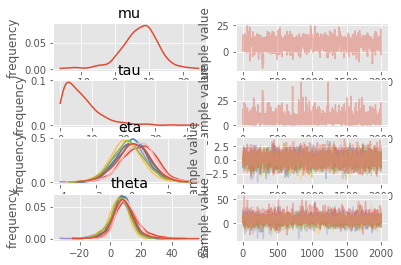

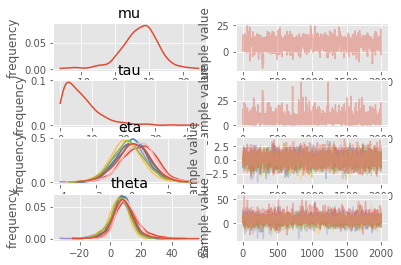

In [60]:
fit1.plot()

### STAN outputs 'Rhat', a comparison of between chain parameter variance to within chain parameter variance. Rhat is always greater than 1. Lower values suggest better mixing. Rhat > 1.1 suggests running the chain longer could improve mixing. In this case, Rhat =1.0 is less than 1.1 which implies the chains have attained good convergence

## sample plot for tau (extendable to all the parameters listed in the fit())

In [61]:
la1 = fit1.extract(permuted=True)  # return a dictionary of arrays
la1['tau'].mean()

6.678618769836728

Text(0.5, 1.0, 'Posterior Distribution')

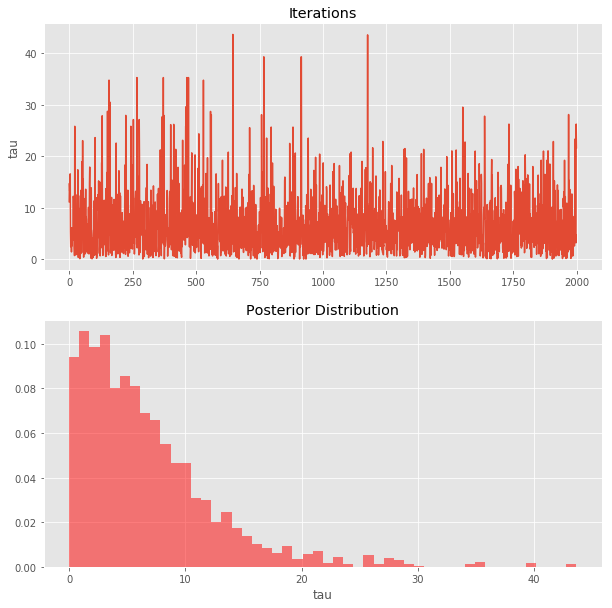

In [62]:
f, axarr = plt.subplots(2,figsize=(10,10))

axarr[0].plot(la1['tau'])
axarr[0].set_ylabel("tau")
axarr[0].set_title("Iterations")

axarr[1].hist(la1['tau'], bins=50, density=True, alpha=0.5,
         histtype='stepfilled', color='red',
         edgecolor='none');
axarr[1].set_xlabel("tau")
axarr[1].set_title("Posterior Distribution")


C:\Users\Karthik\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


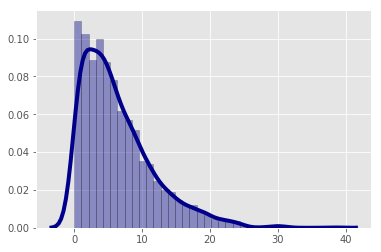

In [74]:


sns.distplot(la['tau'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

## Problem 2
Since we did not specify a prior for $\tau$ in the code for Problem 1 Stan automatically assigns it the improper prior $\pi(\tau)\propto 1$, for $\tau >0$ (the constraint specified in the code). In this question we put different priors on $\tau$. Select a suitable prior form of your choice (e.g. Gamma) and select the parameters in three ways:
1. To ensure the posterior is concentrated around relatively small values of $\tau$. 
2. To ensure the posterior is concentrated around relatively large values of $\tau$. 
3. To make the prior relatively non-informative. 

For each case provide a table and plots to summarize the posterior inference. Describe how the inference compares across each of the three cases and explain why your observations make sense. 

## To ensure the posterior is concentrated around relatively small values of  τ .

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0dbf7414431ff4bc043907b9d1c5cabd NOW.


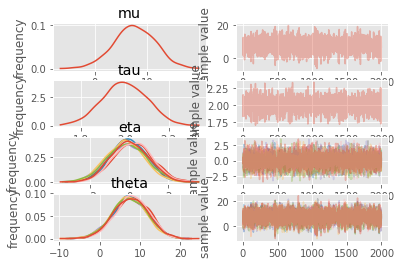

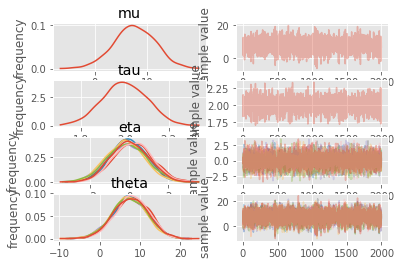

In [64]:
schools_code = """
data {
    int<lower=0> J; // number of schools
    vector[J] y; // estimated treatment effects
    vector<lower=0>[J] sigma; // s.e. of effect estimates
}
parameters {
    real mu;
    real<lower=0> tau;
    vector[J] eta;
}
transformed parameters {
    vector[J] theta;
    theta = mu + tau * eta;
}
model {
    tau ~ normal(2, 0.1);
    eta ~ normal(0, 1);
    y ~ normal(theta, sigma);
}
"""

schools_dat = {'J': 8,
               'y': [28,  8, -3,  7, -1,  1, 18, 12],
               'sigma': [15, 10, 16, 11,  9, 11, 10, 18]}

sm = pystan.StanModel(model_code=schools_code)
fit2a = sm.sampling(data=schools_dat, iter=1000, chains=4)
fit2a.plot()

In [65]:
fit2a

Inference for Stan model: anon_model_0dbf7414431ff4bc043907b9d1c5cabd.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu         7.66    0.06   3.96  -0.45   5.05   7.64  10.43  15.29   4731    1.0
tau         2.0  1.7e-3    0.1    1.8   1.93    2.0   2.07   2.19   3671    1.0
eta[1]      0.2    0.01   1.01  -1.79  -0.47   0.19   0.87   2.15   4889    1.0
eta[2]    -0.01    0.02   0.91  -1.81  -0.64  -0.02   0.61   1.71   3486    1.0
eta[3]    -0.07    0.02   1.04  -2.05   -0.8  -0.09   0.63    2.0   3794    1.0
eta[4]    -0.03    0.01   0.94  -1.84  -0.67  -0.05   0.64   1.78   3918    1.0
eta[5]    -0.21    0.02   0.95  -1.99  -0.86  -0.21   0.43   1.71   3102    1.0
eta[6]    -0.11    0.02   1.03  -2.16  -0.81  -0.11    0.6   1.93   3434    1.0
eta[7]      0.2    0.02   0.97  -1.65  -0.47   0.21   0.86   2.11   4084    1.0
eta[8]     0.

Text(0.5, 1.0, 'Posterior Distribution')

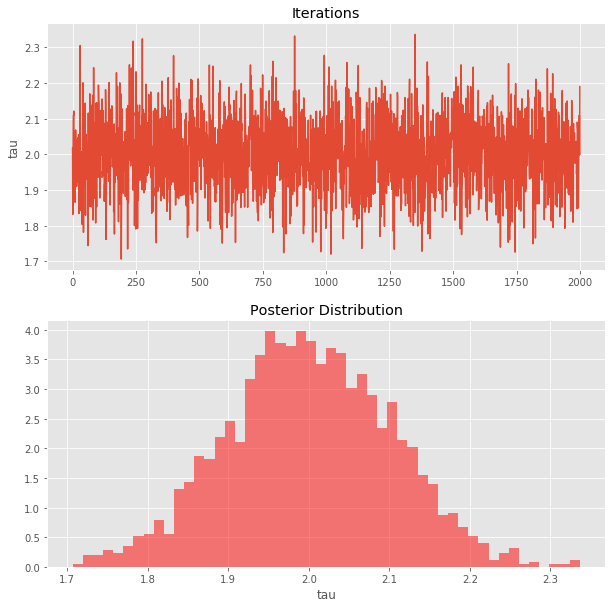

In [66]:
la2a = fit2a.extract(permuted=True)  # return a dictionary of arrays
la2a['tau'].mean()

f, axarr = plt.subplots(2,figsize=(10,10))

axarr[0].plot(la2a['tau'])
axarr[0].set_ylabel("tau")
axarr[0].set_title("Iterations")

axarr[1].hist(la2a['tau'], bins=50, density=True, alpha=0.5,
         histtype='stepfilled', color='red',
         edgecolor='none');
axarr[1].set_xlabel("tau")
axarr[1].set_title("Posterior Distribution")


## To ensure the posterior is concentrated around relatively large values of  τ .

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8ebb731bcdd214f7a1cabb0709631f2e NOW.


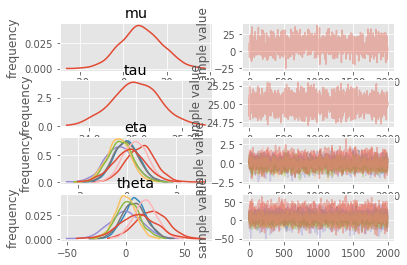

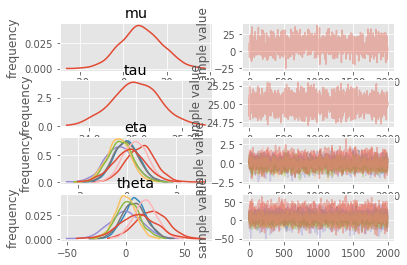

In [67]:
schools_code = """
data {
    int<lower=0> J; // number of schools
    vector[J] y; // estimated treatment effects
    vector<lower=0>[J] sigma; // s.e. of effect estimates
}
parameters {
    real mu;
    real<lower=0> tau;
    vector[J] eta;
}
transformed parameters {
    vector[J] theta;
    theta = mu + tau * eta;
}
model {
    tau ~ normal(25, 0.1);
    eta ~ normal(0, 1);
    y ~ normal(theta, sigma);
}
"""

schools_dat = {'J': 8,
               'y': [28,  8, -3,  7, -1,  1, 18, 12],
               'sigma': [15, 10, 16, 11,  9, 11, 10, 18]}

sm = pystan.StanModel(model_code=schools_code)
fit2b = sm.sampling(data=schools_dat, iter=1000, chains=4)
fit2b.plot()

In [68]:
fit2b

Inference for Stan model: anon_model_8ebb731bcdd214f7a1cabb0709631f2e.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu         8.36    0.39   9.47 -10.16   2.04    8.1  14.78   26.9    600   1.01
tau        25.0  1.5e-3    0.1   24.8  24.93   25.0  25.07   25.2   4459    1.0
eta[1]     0.56    0.02   0.58  -0.56   0.16   0.58   0.93   1.68   1349    1.0
eta[2]    -0.01    0.02    0.5  -0.96  -0.36  -0.02   0.33   0.96    804    1.0
eta[3]    -0.32    0.02   0.58  -1.47  -0.71  -0.32   0.07   0.84   1335    1.0
eta[4]    -0.05    0.02   0.51  -1.03   -0.4  -0.05   0.29   0.97   1024    1.0
eta[5]    -0.33    0.02   0.48  -1.28  -0.64  -0.32  -0.01   0.62    831   1.01
eta[6]    -0.24    0.02   0.51  -1.21  -0.58  -0.26   0.09   0.79    874   1.01
eta[7]     0.34    0.02    0.5  -0.64  -0.01   0.34   0.68   1.33    901    1.0
eta[8]     0.

Text(0.5, 1.0, 'Posterior Distribution')

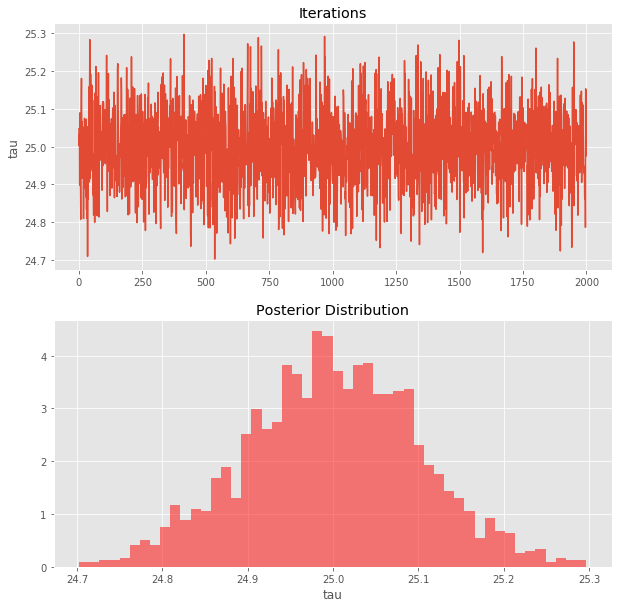

In [69]:
la2b = fit2b.extract(permuted=True)  # return a dictionary of arrays
la2b['tau'].mean()

f, axarr = plt.subplots(2,figsize=(10,10))

axarr[0].plot(la2b['tau'])
axarr[0].set_ylabel("tau")
axarr[0].set_title("Iterations")

axarr[1].hist(la2b['tau'], bins=50, density=True, alpha=0.5,
         histtype='stepfilled', color='red',
         edgecolor='none');
axarr[1].set_xlabel("tau")
axarr[1].set_title("Posterior Distribution")


## To make the prior relatively non-informative.

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ad02563d8022f8bb2a2bd69078e7ad15 NOW.


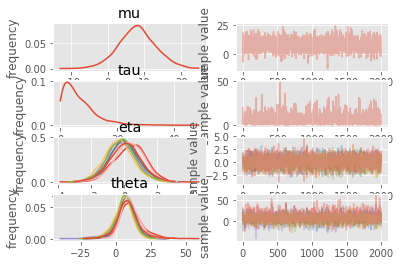

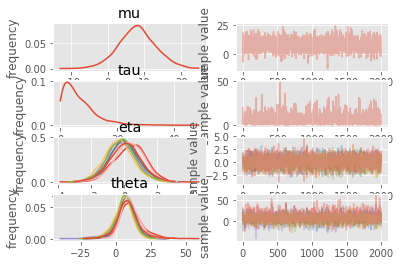

In [70]:
schools_code = """
data {
    int<lower=0> J; // number of schools
    vector[J] y; // estimated treatment effects
    vector<lower=0>[J] sigma; // s.e. of effect estimates
}
parameters {
    real mu;
    real<lower=0> tau;
    vector[J] eta;
}
transformed parameters {
    vector[J] theta;
    theta = mu + tau * eta;
}
model {
    tau ~ normal(20, 500);
    eta ~ normal(0, 1);
    y ~ normal(theta, sigma);
}
"""

schools_dat = {'J': 8,
               'y': [28,  8, -3,  7, -1,  1, 18, 12],
               'sigma': [15, 10, 16, 11,  9, 11, 10, 18]}

sm = pystan.StanModel(model_code=schools_code)
fit2c = sm.sampling(data=schools_dat, iter=1000, chains=4)
fit2c.plot()

In [71]:
fit2c

Inference for Stan model: anon_model_ad02563d8022f8bb2a2bd69078e7ad15.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu         8.04    0.15   5.11  -2.06   4.76   8.08  11.29   18.4   1170    1.0
tau        6.45     0.2   5.72   0.12   2.24   4.92   9.08  20.85    784    1.0
eta[1]     0.37    0.02   0.94  -1.46  -0.29   0.42   1.02   2.12   1904    1.0
eta[2]     0.02    0.02   0.91  -1.74   -0.6  -0.02    0.6   1.92   1726    1.0
eta[3]    -0.18    0.02    0.9  -2.02  -0.77  -0.19   0.41   1.68   1733    1.0
eta[4]  -3.2e-3    0.02    0.9  -1.92  -0.57  -0.02   0.56   1.78   1750    1.0
eta[5]    -0.34    0.02   0.88  -1.98  -0.91  -0.33   0.23   1.47   1541    1.0
eta[6]     -0.2    0.02   0.87  -1.96  -0.76  -0.19   0.34   1.59   1897    1.0
eta[7]     0.29    0.02    0.9   -1.6  -0.28   0.31   0.92   1.93   1972    1.0
eta[8]     0.

Text(0.5, 1.0, 'Posterior Distribution')

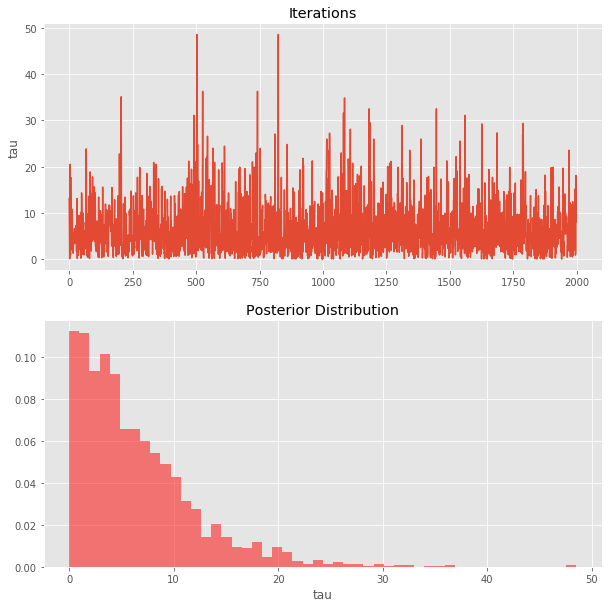

In [72]:
la2c = fit2c.extract(permuted=True)  # return a dictionary of arrays
la2c['tau'].mean()

f, axarr = plt.subplots(2,figsize=(10,10))

axarr[0].plot(la2c['tau'])
axarr[0].set_ylabel("tau")
axarr[0].set_title("Iterations")

axarr[1].hist(la2c['tau'], bins=50, density=True, alpha=0.5,
         histtype='stepfilled', color='red',
         edgecolor='none');
axarr[1].set_xlabel("tau")
axarr[1].set_title("Posterior Distribution")


## Comparison of tau in Q1, Q2a, Q2b, Q2c

Text(0.5, 1.0, 'tau Q2c - Tau Posterior Distribution')

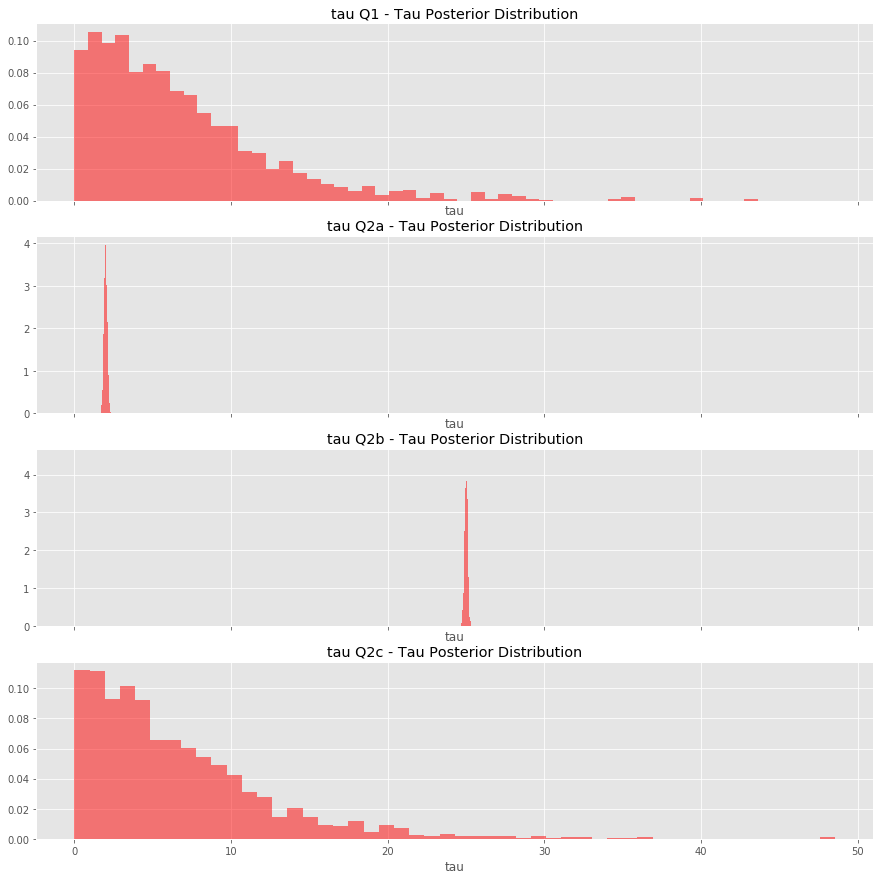

In [73]:

f, axarr = plt.subplots(4,figsize=(15,15),sharex = True)


axarr[0].hist(la1['tau'], bins=50, density=True, alpha=0.5,
         histtype='stepfilled', color='red',
         edgecolor='none');
axarr[0].set_xlabel("tau")
axarr[0].set_title("tau Q1 - Tau Posterior Distribution")

axarr[1].hist(la2a['tau'], bins=50, density=True, alpha=0.5,
         histtype='stepfilled', color='red',
         edgecolor='none');
axarr[1].set_xlabel("tau")
axarr[1].set_title("tau Q2a - Tau Posterior Distribution")

axarr[2].hist(la2b['tau'], bins=50, density=True, alpha=0.5,
         histtype='stepfilled', color='red',
         edgecolor='none');
axarr[2].set_xlabel("tau")
axarr[2].set_title("tau Q2b - Tau Posterior Distribution")

axarr[3].hist(la2c['tau'], bins=50, density=True, alpha=0.5,
         histtype='stepfilled', color='red',
         edgecolor='none');
axarr[3].set_xlabel("tau")
axarr[3].set_title("tau Q2c - Tau Posterior Distribution")


### Rhat in all the above plots in Q2a,b,c are <1.1 . Hence all the chains are converging. 


### - It can be seen that in Q2a, Tau is concentrated on the lower value around 2 as the prior on tau is given by a normal distribution of N(2,0.01). The posterior output is heavily concentrated around the prior given because the standard deviation on the prior is low and hence a strong prior outweighs the likelihood calculations across chain iterations though STAN MCMC.



### - It can be seen that in Q2b, Tau is concentrated on the higher value around 25 as the prior on tau is given by a normal distribution of N(25,0.1). The posterior output is heavily concentrated around the prior given because the standard deviation on the prior is low and hence a strong prior outweighs the likelihood calculations across chain iterations through STAN MCMC.


### - It can be seen that in Q2c, Tau is spread out and similar to the tau from Question 1 as the prior on tau is given by a normal distribution of N(20,500). The posterior output is highly influenced by the liklihood function across chain iterations of STAN MCMC because the standard deviation around the mean on the prior is really high and hence is highly uniformative and gives a similar result to Q1 where there was no prior to aid in getting an accurate posterior.